# EDA Prelim results
- Removing Region 1, Tester name, and Taster twitter handle.
- Removing rows with null entries in description, designation, variety, winery, title.
- Removing rows with null entries in province- they also have null entries for region_1
- A large share wines in the dataset comes from the US (especially California).
- Some popular grape types are Pinor Noir, Chardonnay, Red Blend, Cabernet Sauvignon.

- Most wines in our data has only 1 review --> potential bias if we want to use these reviews to predict the exact wine.

    - 91% of wine titles has only 1 review - these reviews make up 83% of review data
    
    - 60% of wine designations has only 1 review - these reviews make up 75% of review data

- In case we use the Classification approach, check if a wine style has sufficient number of reviews. I consider 3 defitions for style: *province-variety*, *province-variety with modifications*, and *province-variety-winery*. 

    - *province-variety* seems to be a better definition, because most styles defined as such has at least 80 reviews. If we discards all style with < 80 reviews, we retain 80% of review data. This yields 181 styles, with a mean review counts for each style being 388 reviews.
        - California groups still dominate the PCA viz
    -  *province-variety with mod* seems to be a better definition, because most styles defined as such has at least 80 reviews. If we discards all style with < 80 reviews, we retain 80% of review data. This yields 212 styles, with a mean review counts for each style being 280 reviews.
    
        - pie chart of styles with at least 80 reviews shows that no style dominates the sample.
        - Better for PC viz
        
    - *province-variety-winery* result in style groups that are too grnular - max count per style is 140, min count is much smaller --> Drop

- Check some meta features of the reviews to ensure they are not to short or too long to be chopped off by the transformer algorithms. Everything checks out: length of the reviews are not too long or too short.
    - Concatenated reviews are also below the 256-word cutoff.

- Visualize some most common words: 'flavor', 'fruit', 'finish', 'palate', 'acidity'

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string 
import re
import spacy

To read csv file in a different directory - Copied the path by the *copy path* option in the right click of that file. Replace forward slash \ with / or \\ or (r"C:\... path of the file")

In [57]:
wine = pd.read_csv('../Data/Raw Data/winemag-data-130k-v2.csv', encoding='utf-8')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Data cleaning

### Clean up 'region_1' variable

In [58]:
# Replace 'region_1' with 'province' if NA
wine['region_1'].mask(wine['region_1'].isna(), wine['province'], inplace=True)

# Remove the word "County" in column 'region_1'
wine['region_1b'] = wine['region_1'].str.replace('County', '')
wine['region_1b'] = wine['region_1b'].str.replace(' -', '-')
wine['region_1b'] = wine['region_1b'].str.strip()

# Group by 'province' and 'region_1b', then drop colum 'id' in the goup-by table since it's a placeholder column to perform groupby
reg_top3prov = wine[wine['province'].isin(['California', 'Washington', 'Oregon']) ].groupby(['province', 'region_1b']).id.count().reset_index()
reg_top3prov.drop('id', axis=1, inplace=True)

# California
ca_reg = reg_top3prov[reg_top3prov['province']=='California' ].copy()
ca_reg['region_1c'] = reg_top3prov[reg_top3prov['province']=='California' ]['region_1b'].\
                        apply(lambda x:  '-'.join(sorted(list(set(x.split('-'))))) )
ca_reg['region_1c'].mask(ca_reg['region_1c']=='Mt. Harlan', 'Mount Harlan', inplace=True)

# Washington
wa_reg = reg_top3prov[reg_top3prov['province']=='Washington' ].copy()
wa_reg['region_1c'] = wa_reg['region_1b']
wa_reg['region_1c'].mask(wa_reg['region_1c']=='Columbia Valley', 'Columbia Valley (WA)', inplace=True)
wa_reg['region_1c'].mask(wa_reg['region_1c']=='Columbia Valley-Walla Walla Valley', 'Walla Walla Valley (WA)', inplace=True)


In [59]:
# Merge CA regions back to wine dataset
wine = wine.merge(ca_reg, how='left', on=['province', 'region_1b'] )
wine['region_1b'].mask(~wine['region_1c'].isna(), wine['region_1c'], inplace=True) 
wine.drop(['region_1c'], axis=1, inplace=True)

In [60]:
# Merge WA regions back to wine dataset
wine = wine.merge(wa_reg, how='left', on=['province', 'region_1b'] )
wine['region_1b'].mask(~wine['region_1c'].isna(), wine['region_1c'], inplace=True) 
wine.drop(['region_1c'], axis=1, inplace=True)

In [61]:
# Oregon: keep 'Willamette Valley', 'Dundee Hills', 'Chehalem Mountains' in 'region_1b'
# change all other regions to 'Oregon Other'
# wine['region_1c'] = wine['region_1b']
wine['region_1b'].mask((~wine['region_1b'].isin(['Willamette Valley', 'Dundee Hills', 'Chehalem Mountains']) 
                        & (wine['province']=='Oregon') ), 
                       'Oregon Other', inplace=True) 

# Rename 'region_1b' as 'region_cleaned'
wine.rename(columns={'region_1b': 'region_cleaned'}, inplace=True)
wine.columns

Index(['id', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery',
       'region_cleaned'],
      dtype='object')

### Clean up 'province' variable

In [62]:
# Replace 'province' with 'region_cleaned' if province==NA
wine['province'].mask(wine['province'].isna(), wine['region_cleaned'], inplace=True)


### Change dtypes of 'points' and 'price'

In [63]:
# Change dtypes of 'points' and 'price'
wine['points'] = wine['points'].astype('float')
wine['price'] = wine['price'].astype('float')

### Remove Unnecessary Columns

Removing Region 1, Tester name, and Taster twitter handle.

In [64]:
wine.drop(['region_2','taster_name','taster_twitter_handle'], axis=1, inplace = True)

### Removing Rows with NaN entries

Removing rows with null entries in the description, designation, variety, winery, title.

 The *dropna()* method removes all rows that contain null values in the specified column.


In [65]:
wine.dropna(subset=['description','designation','title','variety','winery', 'country'], inplace=True)
# Note: all reviews with 'country' == NA also have NA values for 'province' and 'region'

### Check 'title' columm - how many reviews per title?

In [66]:
# No missing title
wine['title'].isnull().values.any()

False

Now we want to make sure we have enough reviews per wine variety!

In [67]:
print(wine['title'].value_counts())

title
Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                         11
Korbel NV Brut Sparkling (California)                                           9
Segura Viudas NV Extra Dry Sparkling (Cava)                                     8
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                         7
Ruinart NV Brut Rosé  (Champagne)                                               7
                                                                               ..
Chaleur Estate 2007 Blanc White (Columbia Valley (WA))                          1
Williams Selyem 2006 Bucher Vineyard Pinot Noir (Russian River Valley)          1
Morgan 2006 Rosella's Vineyard Pinot Noir (Santa Lucia Highlands)               1
Morgan 2006 Garys' Vineyard Pinot Noir (Santa Lucia Highlands)                  1
Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)     1
Name: count, Length: 84502, dtype: int64


In [68]:
# Check how many wine titles have only 1 reviews --> 83% of reviews describe 1 unique wine title
tab_by_title = wine.groupby('title')['id'].count().reset_index()
tab_by_title.rename(columns={'id':'count'}, inplace=True)
tab_by_title.sort_values('count', ascending=False, inplace=True)
tab_by_title['tot_count'] = tab_by_title['count'].sum()
tab_by_title['share'] = tab_by_title['count']/tab_by_title['tot_count']
tab_by_title['share_cum'] = tab_by_title['share'].cumsum()

display(tab_by_title[tab_by_title['count']>1].tail()) # 1-0.16824 = 0.83176

,title,count,tot_count,share,share_cum
26546,Domaine de l'Idylle 2015 Cruet Jacquère (Savoie),2,92454,0.000022,0.168213
60149,Piccini 2009 Villa al Cortile Riserva (Brunel...,2,92454,0.000022,0.168235
48040,Lobo 2010 Wulff Vineyards Chardonnay (Oak Knol...,2,92454,0.000022,0.168257
47544,Les Vignobles Gueissard 2015 Cuvée G Rosé (Ban...,2,92454,0.000022,0.168278
65648,Rocca di Frassinello 2013 Baffonero (Maremma ...,2,92454,0.000022,0.168300


In [69]:
print('Share of wine titles with at least 2 reviews:', len(tab_by_title[tab_by_title['count']>=2])/len(tab_by_title))
print('Share of wine titles with at least 5 reviews:', len(tab_by_title[tab_by_title['count']>=5])/len(tab_by_title))

Share of wine titles with at least 2 reviews: 0.09003337199119547
Share of wine titles with at least 5 reviews: 0.0003668552223616009


In [70]:
# Check how many wine designations have only 1 review --> 25% of reviews describe 1 unique wine designation
# Check how many wine designations have less than 5 reviews --> 65% of reviews describe 1 unique wine designation
tab_by_desig = wine.groupby('designation')['id'].count().reset_index()
tab_by_desig.rename(columns={'id':'count'}, inplace=True)
tab_by_desig.sort_values('count', ascending=False, inplace=True)
tab_by_desig['tot_count'] = tab_by_desig['count'].sum()
tab_by_desig['share'] = tab_by_desig['count']/tab_by_desig['tot_count']
tab_by_desig['share_cum'] = tab_by_desig['share'].cumsum()

display(tab_by_desig[tab_by_desig['count']>5].tail()) # 1-0.368171 = 0.631829
display(tab_by_desig[tab_by_desig['count']>2].tail()) # 1-0.591583 = 0.408417
display(tab_by_desig[tab_by_desig['count']>1].tail()) # 1-0.753065 = 0.2469

,designation,count,tot_count,share,share_cum
28680,Rock Hound,6,92454,0.000065,0.367859
9457,D,6,92454,0.000065,0.367924
17307,Kittmannsberg Reserve,6,92454,0.000065,0.367988
2242,Authentique,6,92454,0.000065,0.368053
14069,Georges de Latour Private Reserve,6,92454,0.000065,0.368118


,designation,count,tot_count,share,share_cum
17348,Knotty Vines,3,92454,0.000032,0.591570
34303,Topaz Impérial,3,92454,0.000032,0.591602
6026,CdR,3,92454,0.000032,0.591635
6042,Cedrus,3,92454,0.000032,0.591667
6054,Celebris Vintage Extra Brut,3,92454,0.000032,0.591700


,designation,count,tot_count,share,share_cum
10168,Dom Martinho,2,92454,0.000022,0.753034
10288,Domaine Mouréou,2,92454,0.000022,0.753056
31756,St. Clair Vineyard,2,92454,0.000022,0.753077
10351,Domaine de Lavernée,2,92454,0.000022,0.753099
8896,Cuvée Gladiateur,2,92454,0.000022,0.753120


In [71]:
print('Share of wine designations with at least 2 reviews:', len(tab_by_desig[tab_by_desig['count']>=2])/len(tab_by_desig))
print('Share of wine designations with at least 5 reviews:', len(tab_by_desig[tab_by_desig['count']>=5])/len(tab_by_desig))

Share of wine designations with at least 2 reviews: 0.39861411181957107
Share of wine designations with at least 5 reviews: 0.07812088317436898


### Create columns 'style1', 'style2', 'style3'

In [72]:
wine['style1'] = wine['variety'] + ' - ' + wine['province']
wine['style2'] = wine['style1']
wine['style2'].mask( wine['province'].isin(['California', 'Oregon']), wine['variety'] + ' - ' + wine['region_cleaned'] , inplace=True)
wine['style3'] = wine['variety'] + ' - ' + wine['province'] + ' - ' + wine['winery']

# Visualization

## Check distribution of countries

First, let's look at the **distribution of countries** with the help of pie-chart.

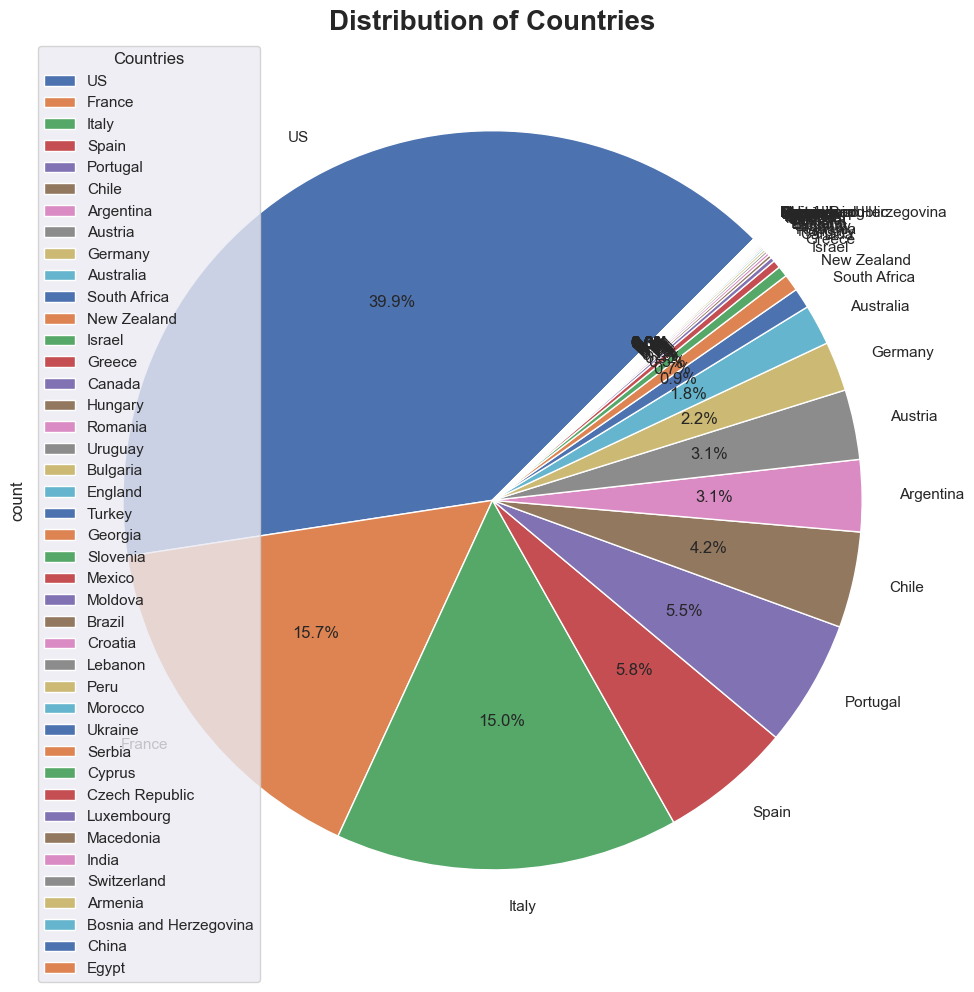

In [73]:
fig = plt.figure(figsize=(12,12))
number_countries = wine['country'].value_counts()
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
plt.legend(title="Countries")
plt.title("Distribution of Countries", fontsize ='20', fontweight = 'bold')
plt.show()

## Check distribution of variety (grape type)

Now, let's look at the **Distribution of variety (grape type)**

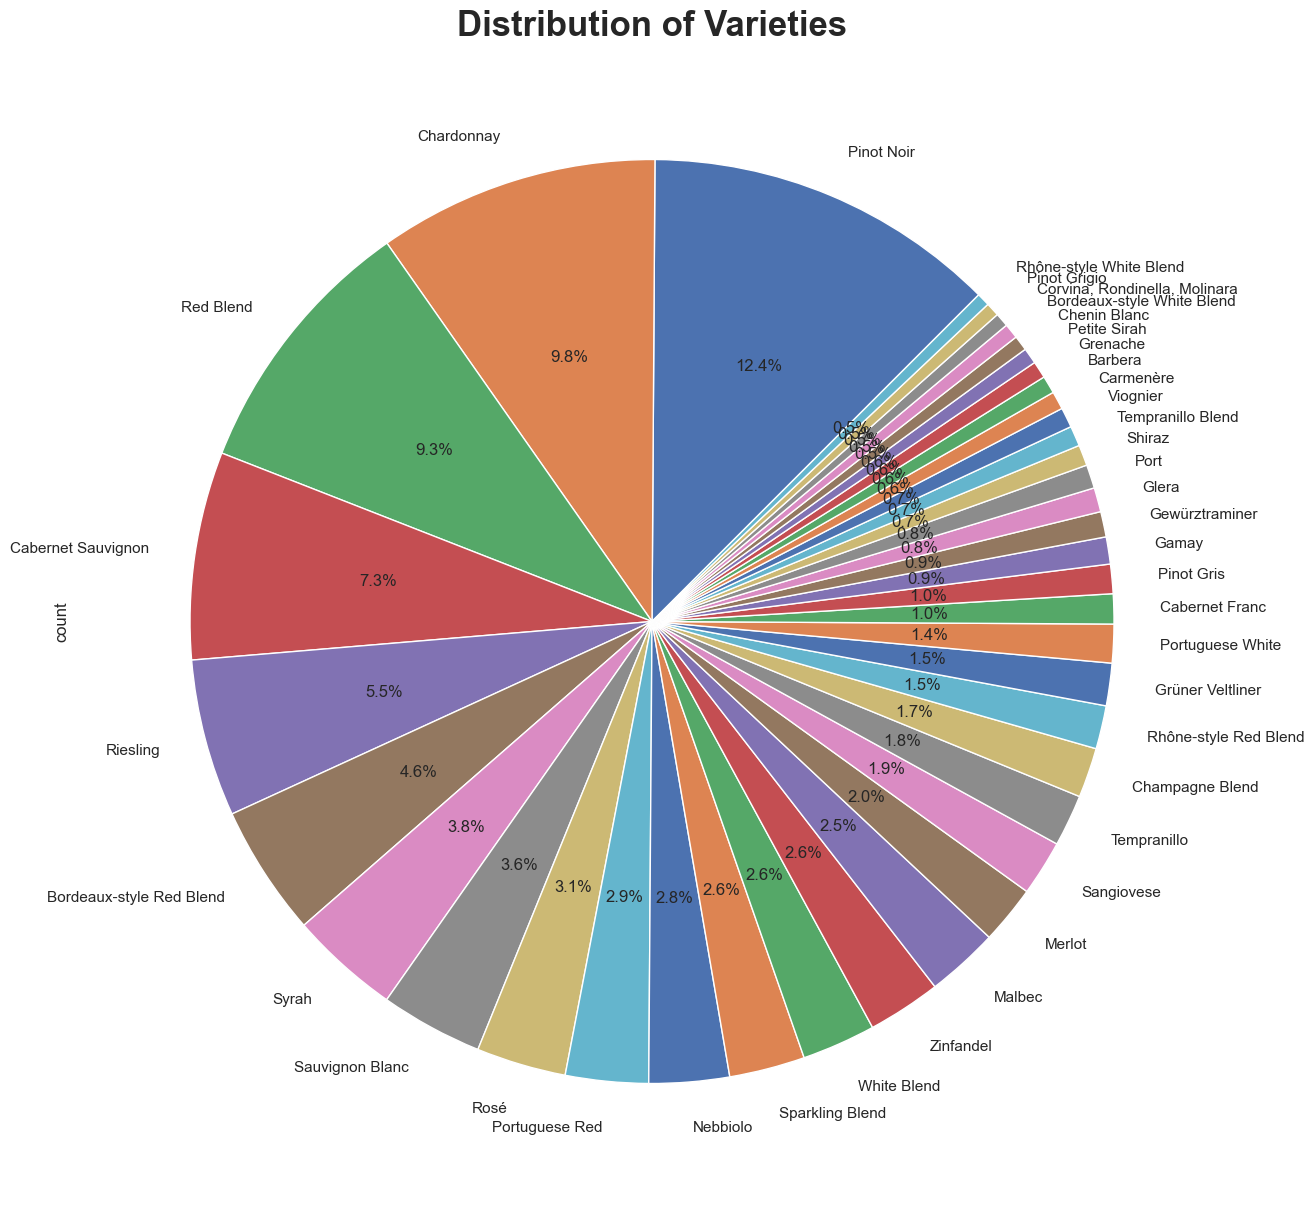

In [74]:
fig = plt.figure(figsize=(15,15))
number_countries = wine['variety'].value_counts()[:40]
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
# plt.legend(title="Varieties")
plt.title("Distribution of Varieties", fontsize ='25', fontweight = 'bold')
plt.show()

## Check distribution of province

Finally, **Distribution of Province** 

In [75]:
province = wine['province'].value_counts()
province

province
California                 24359
Washington                  5892
Oregon                      3789
Tuscany                     3728
Northern Spain              3077
                           ...  
Markopoulo                     1
Waitaki Valley                 1
Corinthia                      1
Slovenska Istra                1
Vin de Pays de Velvendo        1
Name: count, Length: 406, dtype: int64

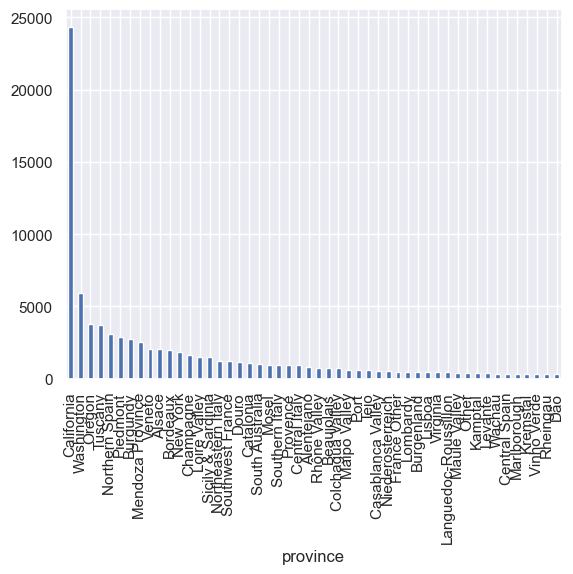

In [76]:
wine['province'].value_counts()[:50].plot(kind = 'bar')
plt.show()

## Check wine *style* definition

In [77]:
# Define bar_chart_top20 function with seaborn styling
def bar_chart_top20(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[0:20]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

# Define bar_chart_top50 function with seaborn styling
def bar_chart_top50(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[0:50]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

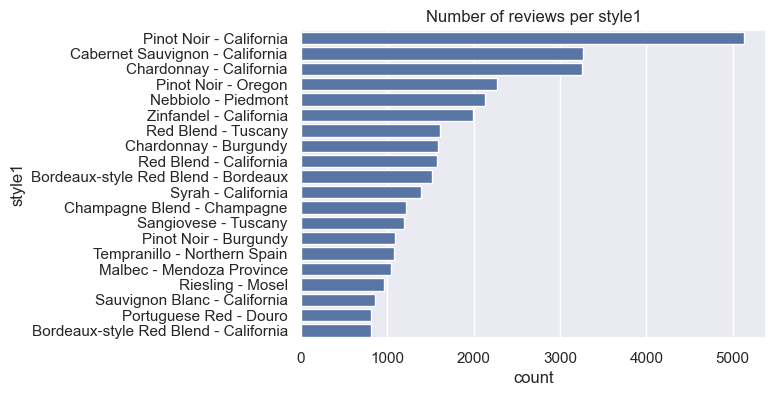

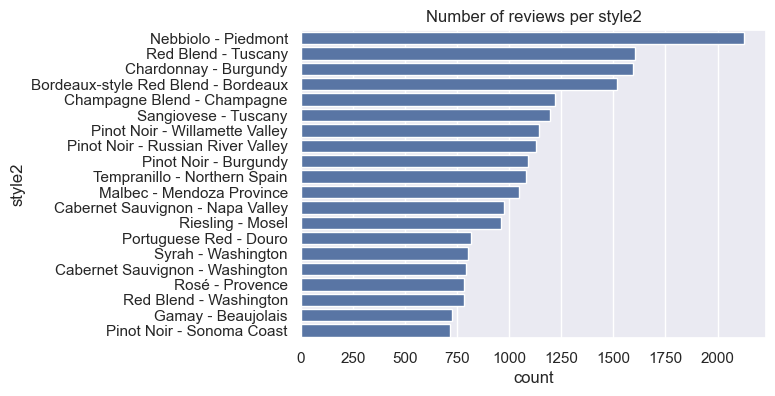

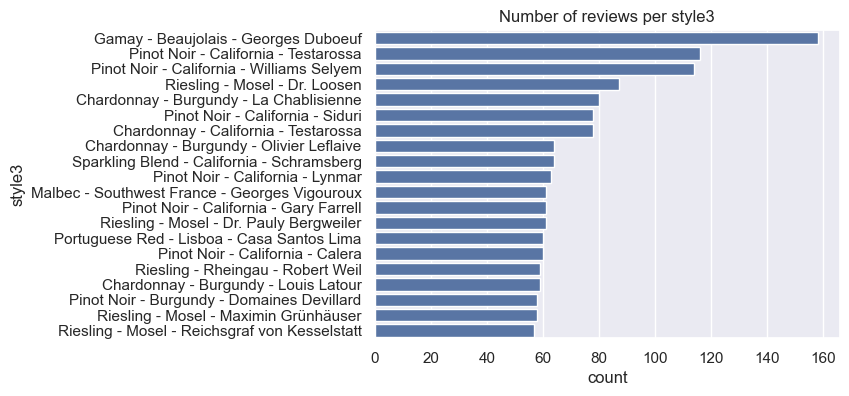

In [78]:
bar_chart_top20(wine, 'style1') # some styles in California is very large (b/c California makes up a huge share in the dataset)
bar_chart_top20(wine, 'style2') ## pretty good
bar_chart_top20(wine, 'style3') # too fine, many categories will have too few reviews

In [79]:
# Check how much of the sample is left if drop wine style with less than 80 reviews --> 80% of sample
tab_by_style1 = wine.groupby('style1')['id'].count().reset_index()
tab_by_style1.rename(columns={'id':'count'}, inplace=True)
tab_by_style1.sort_values('count', ascending=False, inplace=True)
tab_by_style1['tot_count'] = tab_by_style1['count'].sum()
tab_by_style1['share'] = tab_by_style1['count']/tab_by_style1['tot_count']
tab_by_style1['share_cum'] = tab_by_style1['share'].cumsum()

display(tab_by_style1[tab_by_style1['count']>=80].tail())
print('Mean review count per style =', tab_by_style1[tab_by_style1['count']>=80]['count'].mean())


,style1,count,tot_count,share,share_cum
1152,Grüner Veltliner - Weinviertel,81,92454,0.000876,0.757609
1102,Grenache - Washington,81,92454,0.000876,0.758485
1383,Merlot - New York,81,92454,0.000876,0.759361
2442,Rosé - France Other,80,92454,0.000865,0.760227
3000,Syrah - Tuscany,80,92454,0.000865,0.761092


Mean review count per style = 388.76243093922653


In [80]:
# Check how much of the sample is left if drop wine style2 with less than 80 reviews --> 60% of sample
tab_by_style2 = wine.groupby('style2')['id'].count().reset_index()
tab_by_style2.rename(columns={'id':'count'}, inplace=True)
tab_by_style2.sort_values('count', ascending=False, inplace=True)
tab_by_style2['tot_count'] = tab_by_style2['count'].sum()
tab_by_style2['share'] = tab_by_style2['count']/tab_by_style2['tot_count']
tab_by_style2['share_cum'] = tab_by_style2['share'].cumsum()

display(tab_by_style2[tab_by_style2['count']>=80].tail())
print('Mean review count per style =', tab_by_style2[tab_by_style2['count']>=80]['count'].mean())


,style2,count,tot_count,share,share_cum
656,Cabernet Sauvignon - Stags Leap District,80,92454,0.000865,0.639886
4493,Syrah - Tuscany,80,92454,0.000865,0.640751
5066,White Blend - California,80,92454,0.000865,0.641616
3619,Rosé - France Other,80,92454,0.000865,0.642482
1092,Chardonnay - Oregon Other,80,92454,0.000865,0.643347


Mean review count per style = 280.5660377358491


In [81]:
print('Style = province x variety, number of classes =', len(wine['style1'].unique()))
print('Style = province x variety with mod, number of classes =', len(wine['style2'].unique()))
print('Style = province x variety x winery, number of classes =', len(wine['style3'].unique()))

print('Style = province x variety, number of classes if drop classes <80 reviews =',len(tab_by_style1[tab_by_style1['count']>=80]))
print('Style = province x variety with mod, number of classes if drop classes <80 reviews =', len(tab_by_style2[tab_by_style2['count']>=80]))

Style = province x variety, number of classes = 3575
Style = province x variety with mod, number of classes = 5349
Style = province x variety x winery, number of classes = 32148
Style = province x variety, number of classes if drop classes <80 reviews = 181
Style = province x variety with mod, number of classes if drop classes <80 reviews = 212


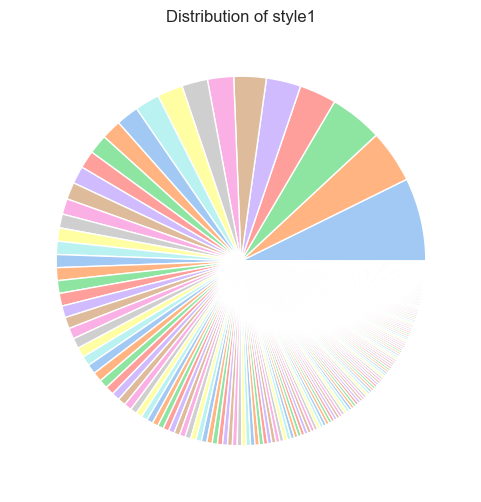

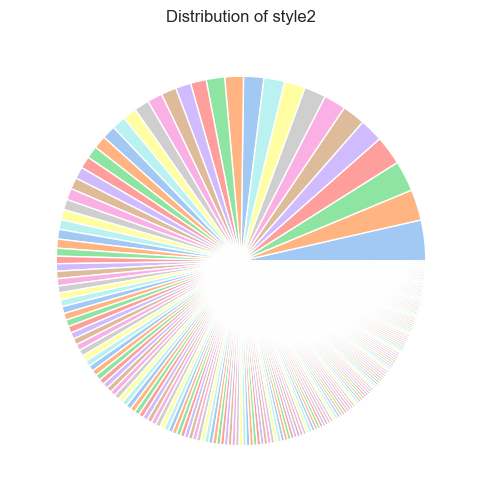

In [82]:
# Define pie_chart function with seaborn styling
def pie_chart(data, var_name, name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,6))
    colors = sns.color_palette("pastel", n_colors=len(data))
    plt.pie(data=data, x=var_name, colors=colors)
    plt.title(f'Distribution of {name}') 
    plt.show()
    return 


# Check the relative size of each class (style)
pie_chart(tab_by_style1[tab_by_style1['count']>=80], 'count', 'style1')
pie_chart(tab_by_style2[tab_by_style2['count']>=80], 'count', 'style2')


In [83]:
# Drop 'style3'
wine.drop('style3', axis=1, inplace=True)

## Check meta features of reviews

**word count**, unique word count, stop word count, mean word length ,character count, punctuation count

In [84]:
from spacy.lang.en.stop_words import STOP_WORDS

In [85]:
word_count = [ len(r.split()) for r in wine['description'] ]
unique_word_count = wine['description'].apply(lambda x: len(set(x.split())))
#  [ len(set(r.split())) for r in wine['description']] 
stop_word_count = wine['description'].apply(lambda x: len(set(x.split()) & STOP_WORDS))
mean_word_length = wine['description'].apply(lambda x: sum(map(len, x.split()))/len(x.split()) )
character_count = wine['description'].apply(lambda x: len(x.replace(' ',''))) # exclusing space
punctuation_count = wine['description'].apply(lambda x: len(re.findall(f'[{string.punctuation}]', x)))

In [86]:
meta_list = [word_count, 
             unique_word_count,
             stop_word_count, 
             mean_word_length,
             character_count, 
             punctuation_count]
meta_features = pd.DataFrame(meta_list).T
meta_features.columns = ['word_count', 
                         'unique_word_count',
                         'stop_word_count', 
                         'mean_word_length',
                         'character_count', 
                         'punctuation_count']

In [87]:
# Check min and max word counts
print('min word count = ', meta_features.word_count.min())
print('max word count = ', meta_features.word_count.max())

min word count =  3.0
max word count =  135.0


In [88]:
# Define histogram function with seaborn styling
def hist_plot(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.histplot(data=data, x=var_name)
    plt.title(f'Histogram of {var_name}') 
    plt.show()
    return ax

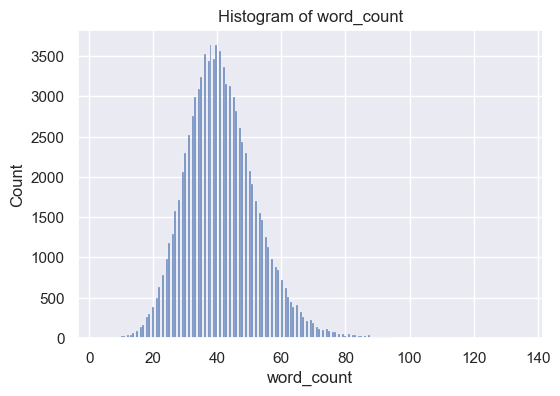

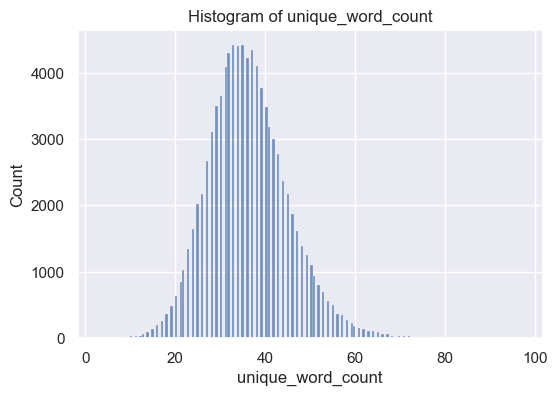

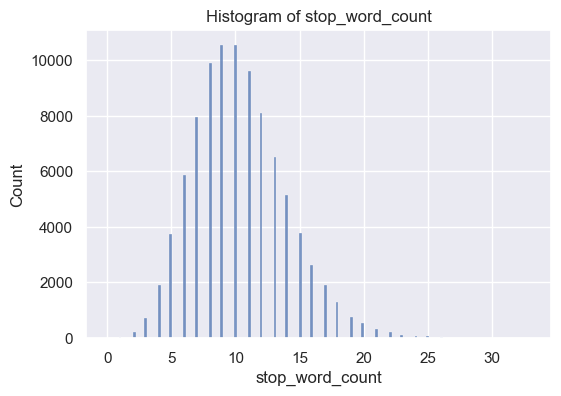

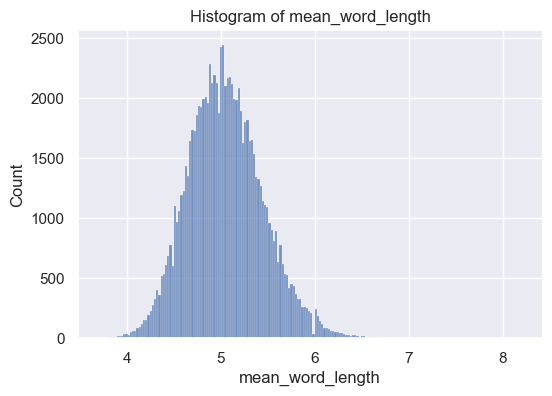

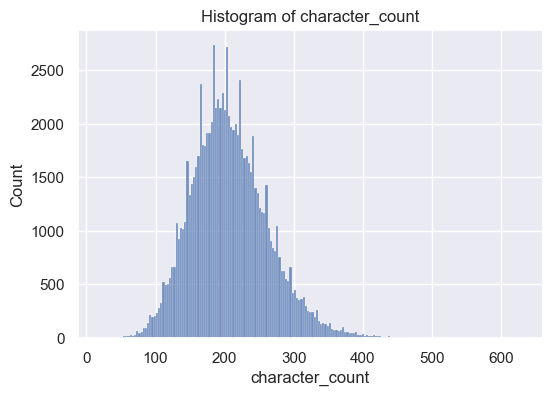

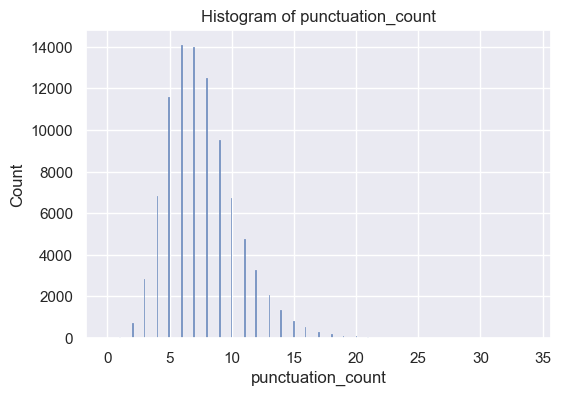

In [89]:
for f in meta_features:
    hist_plot(meta_features, f)

## Polular N-grams

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load("en_core_web_sm")


In [91]:
to_remove = [c for c in string.punctuation]
to_remove.append('wine')

In [92]:
# Unigrams
def tokenize_lemma(text):
    return [w.lemma_.lower() for w in nlp(text)]

stop_words_lemma = list(tokenize_lemma(' '.join(STOP_WORDS)))

unigr_counter = CountVectorizer(max_features=50, 
                                tokenizer = tokenize_lemma,
                                stop_words = stop_words_lemma) 

wine_1gram = unigr_counter.fit_transform(wine['description'] )
wine_1gram_df = pd.DataFrame(wine_1gram.toarray(), columns=unigr_counter.get_feature_names_out())

# remove punctuation characters + the word 'wine' since it's not helpful
wine_1gram_df = wine_1gram_df.loc[:, ~wine_1gram_df.columns.isin(to_remove)] 

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn(


In [93]:
# Bigrams
bigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(2,2), 
                             stop_words=list(STOP_WORDS) )

wine_2gram = bigr_counter.fit_transform( wine['description']  )
wine_2gram_df = pd.DataFrame(wine_2gram.toarray(), columns=bigr_counter.get_feature_names_out())

# remove punctuation characters
wine_2gram_df = wine_2gram_df.loc[:, ~wine_2gram_df.columns.isin(set(to_remove))] 

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [94]:
# Trigrams
trigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(3,3), 
                             stop_words=list(STOP_WORDS) )

wine_3gram = trigr_counter.fit_transform( wine['description']  )
wine_3gram_df = pd.DataFrame(wine_3gram.toarray(), columns=trigr_counter.get_feature_names_out())

# remove punctuation characters
wine_3gram_df = wine_3gram_df.loc[:, ~wine_3gram_df.columns.isin(set(to_remove))]

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [95]:
# Check global list of names associated with wine_3gram_df
[name for name in globals() if globals()[name] is wine_3gram_df]

['wine_3gram_df']

In [96]:
# Define function to print out name of an object
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# Define bar_chart_top_ngrams function with seaborn styling
def bar_chart_top_ngrams(data):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    collapsed_df = data.sum(axis=0).reset_index()
    collapsed_df.columns = ['ngram', 'count']
    collapsed_df.sort_values('count', ascending=False, inplace=True)
    df_plotted = namestr(data, globals())
    sns.barplot(collapsed_df, x='count', y='ngram', hue='ngram', legend=False) 
    plt.title(f'Counts per n-gram, {df_plotted}') 
    plt.show()
    return ax

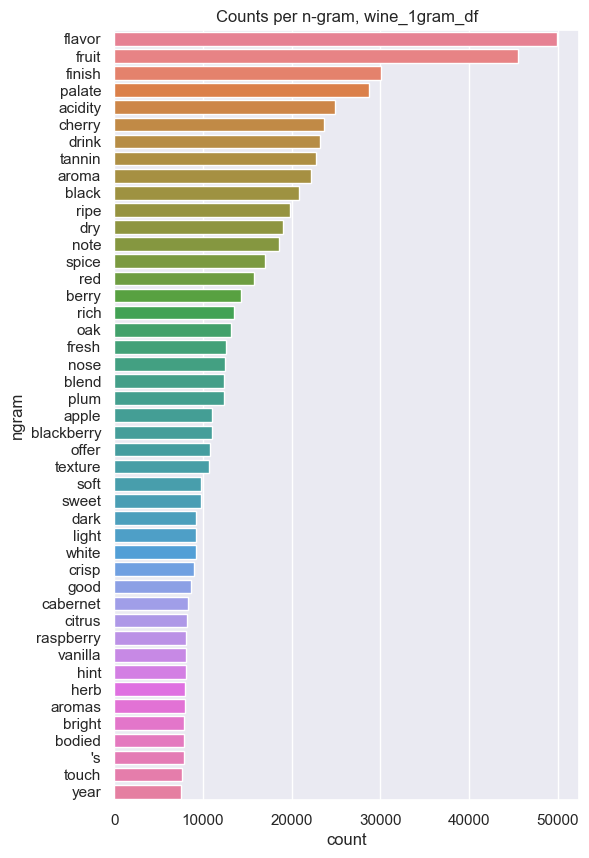

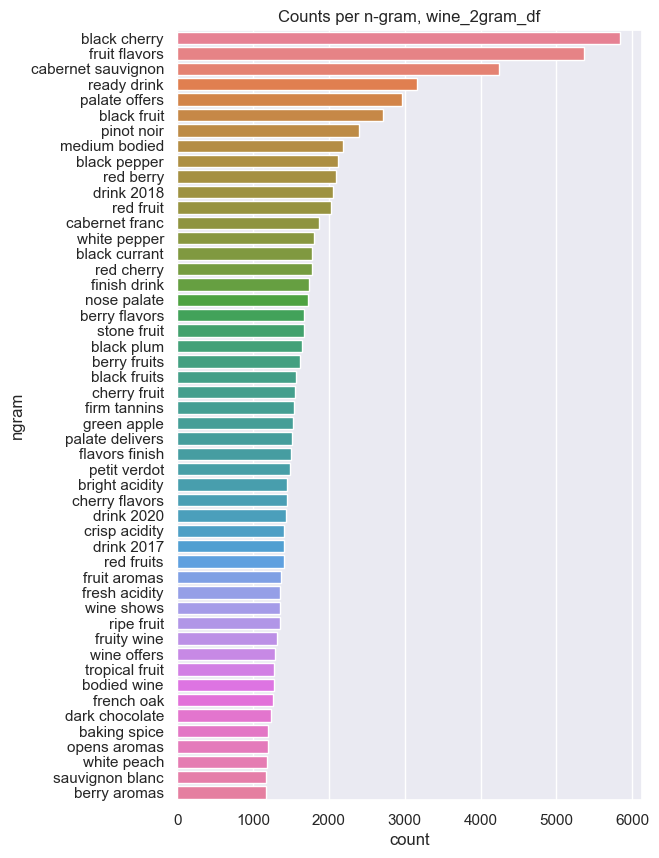

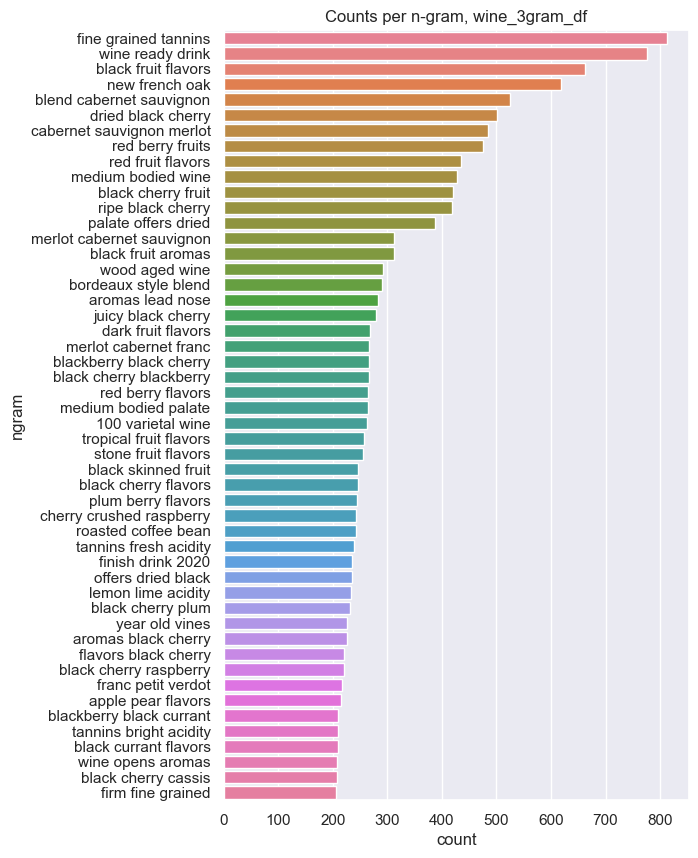

In [97]:
ngram_df_list = [wine_1gram_df, wine_2gram_df, wine_3gram_df]

for df in ngram_df_list:
    bar_chart_top_ngrams(df)


# Concatenate reviews of the same wine 'title'

In [98]:
# Count the number of reviews per title
wine['title_count'] = wine.groupby('title')['id'].transform('count')

# Subset titles with multiple reviews
mult_revs = wine[wine['title_count']>1].sort_values(['title', 'id']).copy()

# Create a column to index the reviews wihtin each title
mult_revs['_n'] = mult_revs.groupby('title').cumcount()+1

# Change dtypes of 'points' and 'price'
mult_revs['points'] = mult_revs['points'].astype('float')
mult_revs['price'] = mult_revs['price'].astype('float')

In [99]:
# Reshape wide mult_revs --> get reviews in columns and each title is a row
mult_revs_wide = mult_revs.pivot(index='title', values=['description', 'points', 'price'], columns='_n').reset_index()
mult_revs_wide.columns = [mult_revs_wide.columns[0][0]] + mult_revs_wide.columns[1:].map('{0[0]}_{0[1]}'.format).to_list()

# Replace NAs in 'description' cols with empty string
mult_revs_wide[mult_revs_wide.columns[1:12]] = mult_revs_wide[mult_revs_wide.columns[1:12]].fillna('')

# Concatenate reviews
mult_revs_wide['rev_mult'] =  mult_revs_wide[mult_revs_wide.columns[1:12]].apply(lambda x: ' '.join(x), axis=1)
mult_revs_wide['rev_mult'] = mult_revs_wide['rev_mult'].str.strip()

# Average price and points
mult_revs_wide['points_mult'] =  mult_revs_wide[mult_revs_wide.columns[12:23]].mean(axis=1)
mult_revs_wide['price_mult'] = mult_revs_wide[mult_revs_wide.columns[23:34]].mean(axis=1)

# Keep only the long review
mult_revs_wide = mult_revs_wide[['title', 'rev_mult', 'points_mult', 'price_mult']]

# Change dtypes of 'points' and 'price'
mult_revs_wide['points_mult'] = mult_revs_wide['points_mult'].astype('float')
mult_revs_wide['price_mult'] = mult_revs_wide['price_mult'].astype('float')

In [100]:
# Merge the long review back to wine df
wine_rev_concat = wine.merge(mult_revs_wide, how='left', on='title')

In [101]:
# Replace column 'description' with 'rev_long'
wine_rev_concat['description'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['rev_mult'], inplace=True)
wine_rev_concat['points'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['points_mult'], inplace=True)
wine_rev_concat['price'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['price_mult'], inplace=True)

# Drop duplicated 'title'
wine_rev_concat.drop_duplicates(subset='title', keep='first', inplace=True)

# drop columns
wine_rev_concat.drop(columns=['rev_mult', 'points_mult', 'price_mult', 'title_count', 'region_1'], inplace=True)

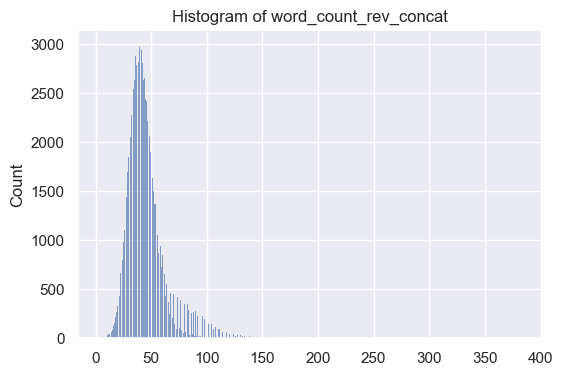

In [102]:
# Check distribution of word count again --> Examine if the max hit 256-word limit
word_count_rev_concat = [ len(r.split()) for r in wine_rev_concat['description'] ]

sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(6,4))
sns.histplot(word_count_rev_concat)
plt.title(f'Histogram of word_count_rev_concat') 
plt.show()

# Save dataset

In [103]:
# Save wine_clean dataset
# drop columns
wine.drop(columns=['title_count', 'region_1'], inplace=True)
wine.to_csv('../Data/Cleaned Data/wine_cleaned.csv', index=False)

In [104]:
# Save wine_cleaned_rev_concat dataset
wine_rev_concat.to_csv('../Data/Cleaned Data/wine_cleaned_rev_concat.csv', index=False)

# PCA Visualization of text embeddings

In [105]:
# # Apply PCA to all vectors
# pca = PCA(n_components=2)
# transformed_vectors = pca.fit_transform(description_embeddings)